#Note: 
- The first cell is the code to plot the heatmap of a portion of GPS logs in the center of Beijing. According to the Geolife user guide, a majority of dataset has been created in Beijing. 
- Running the next cell creates the heatp map as a HTML file. HTML file is saved on a local storage. 
- Heatmap in the HTML file can be zoom-in and zoom-out with Google Maps as the background.
- A screenshot of the HTML is provided in this notebook
- Last cell outputs the imported data for creating the plot. 

In [7]:
import matplotlib.pyplot as plt
import pickle
import time
import gmplot
import random
import numpy as np

filename = '../Mode-codes-Revised/paper2_Trajectory_Label.pickle'
with open(filename, 'rb') as f:
    trajectory_all_user_with_label, trajectory_all_user_wo_label = pickle.load(f)
lat = []
long = []
Beijing = [(39.438178, 41.079483), (115.420143, 117.522504)]  # Beijing GPS coord boundaries.
for user in trajectory_all_user_with_label:
    for gps in user[:1200]:
        if Beijing[0][0] <= gps[0] <= Beijing[0][1] and Beijing[1][0] <= gps[1] <= Beijing[1][1]:
            lat.append(gps[0])
            long.append(gps[1])

for user in trajectory_all_user_wo_label:
    for gps in user[:7000]:  # Using only 7000 GPS logs of every user to make HTML file smaller. 
        if Beijing[0][0] <= gps[0] <= Beijing[0][1] and Beijing[1][0] <= gps[1] <= Beijing[1][1]:
            lat.append(gps[0])
            long.append(gps[1])
# Make half the data point to visualize
lat = lat[:int(1*len(lat))]
long = long[:int(1*len(long))]
gmap = gmplot.GoogleMapPlotter(39.972353, 116.331708, 12)
gmap.heatmap(lat, long)
gmap.draw('HeatMap-Distribution of GPS trajectories in Beijing.html')

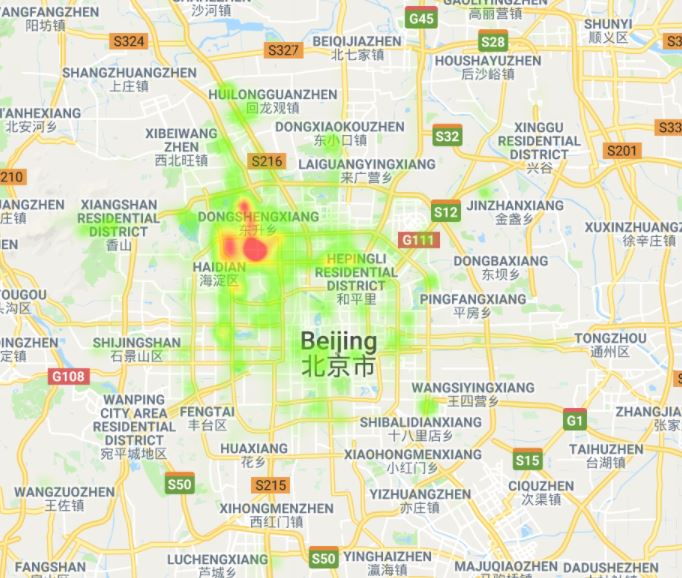

In [1]:
from IPython.core.display import Image 
Image(filename='Data-Incubator-Plot-2.JPG')

Distribution of GPS logs (heatmap) in the central area of Beijing based on Geolife trajectories.  
<img src="Data-Incubator-Plot-2.JPG">

In [ ]:
import pickle
from datetime import datetime
import os
import time
start_time = time.clock()


def days_date(time_str):
    date_format = "%Y/%m/%d %H:%M:%S"
    current = datetime.strptime(time_str, date_format)
    date_format = "%Y/%m/%d"
    bench = datetime.strptime('1899/12/30', date_format)
    no_days = current - bench
    delta_time_days = no_days.days + current.hour / 24.0 + current.minute / (24. * 60.) + current.second / (24. * 3600.)
    return delta_time_days

# Change Mode Name to Mode index
Mode_Index = {"walk": 0, "run": 9, "bike": 1, "bus": 2, "car": 3, "taxi": 3, "subway": 4, "railway": 4,
              "train": 4, "motocycle": 8, "boat": 9, "airplane": 9, "other": 9}

# Ground modes are the modes that we use in this paper.
Ground_Mode = ['walk', 'bike', 'bus', 'car', 'taxi', 'subway', 'railway', 'train']

geolife_dir = '../Geolife Trajectories 1.3-Raw-All/Geolife Trajectories 1.3/Data/'
users_folder = os.listdir(geolife_dir)
trajectory_all_user_wo_label = []
trajectory_all_user_with_label = []
label_all_user = []
for folder in users_folder:
    if len(os.listdir(geolife_dir + folder)) == 1:
        trajectory_dir = geolife_dir + folder + '/Trajectory/'
        user_trajectories = os.listdir(trajectory_dir)
        trajectory_one_user = []
        for plt in user_trajectories:
            with open(trajectory_dir + plt, 'r', newline='', encoding='utf-8') as f:
                GPS_logs = filter(lambda x: len(x.split(',')) == 7, f)
                GPS_logs_split = map(lambda x: x.rstrip('\r\n').split(','), GPS_logs)
                for row in GPS_logs_split:
                    trajectory_one_user.append([float(row[0]), float(row[1]), float(row[4])])
        trajectory_all_user_wo_label.append(trajectory_one_user)

    elif len(os.listdir(geolife_dir + folder)) == 2:
        trajectory_dir = geolife_dir + folder + '/Trajectory/'
        user_trajectories = os.listdir(trajectory_dir)
        trajectory_one_user = []
        for plt in user_trajectories:
            with open(trajectory_dir + plt, 'r', newline='', encoding='utf-8') as f:
                GPS_logs = filter(lambda x: len(x.split(',')) == 7, f)
                GPS_logs_split = map(lambda x: x.rstrip('\r\n').split(','), GPS_logs)
                for row in GPS_logs_split:
                    trajectory_one_user.append([float(row[0]), float(row[1]), float(row[4])])
        trajectory_all_user_with_label.append(trajectory_one_user)

        label_dir = geolife_dir + folder + '/labels.txt'
        with open(label_dir, 'r', newline='', encoding='utf-8') as f:
            label = list(map(lambda x: x.rstrip('\r\n').split('\t'), f))
            label_filter = list(filter(lambda x: len(x) == 3 and x[2] in Ground_Mode, label))
            label_one_user = []
            for row in label_filter:
                label_one_user.append([days_date(row[0]), days_date(row[1]), Mode_Index[row[2]]])
        label_all_user.append(label_one_user)

trajectory_all_user_with_label_Final = []  # Only contain users' trajectories that have labels
for index, user in enumerate(label_all_user):
    trajectory_user = trajectory_all_user_with_label[index]
    classes = {0: [], 1: [], 2: [], 3: [], 4: []}
    start_index = 0
    for row in user:
        if not trajectory_user:
            break

        start = row[0]
        end = row[1]
        mode = row[2]

        if trajectory_user[0][2] > end or trajectory_user[-1][2] < start:
            continue

        for index1, trajectory in enumerate(trajectory_user):
            if start <= trajectory[2] <= end:
                start_index += index1
                trajectory_user = trajectory_user[index1 + 1:]
                break

        if trajectory_user[-1][2] < end:
            end_index = start_index + 1 + len(trajectory_user)
            classes[mode].extend(list(range(start_index, end_index)))
            break
        else:
            for index2, trajectory in enumerate(trajectory_user):
                if trajectory[2] > end:
                    end_index = start_index + 1 + index2
                    trajectory_user = trajectory_user[index2 + 1:]
                    classes[mode].extend(list(range(start_index, end_index)))
                    start_index = end_index + 1
                    break

    for k, v in classes.items():
        for value in v:
            trajectory_all_user_with_label[index][value].append(k)
    labeled_trajectory = list(filter(lambda x: len(x) == 4, trajectory_all_user_with_label[index]))
    trajectory_all_user_with_label_Final.append(labeled_trajectory)
    unlabeled_trajectory = list(filter(lambda x: len(x) == 3, trajectory_all_user_with_label[index]))
    trajectory_all_user_wo_label.append(unlabeled_trajectory)

# Save Trajectory_Array and Label_Array for all users
with open("paper2_Trajectory_Label.pickle", 'wb') as f:
    pickle.dump([trajectory_all_user_with_label_Final, trajectory_all_user_wo_label], f)

print(time.clock() - start_time, 'Seconds')
